# Welcome!

We've got some issues we want to resolve.

- [ ] First, we need to fix the data itself. Right now, there are invalid values for some data points (zero or negative) which get pruned off. Because of this, all of the ANOVAs are throwing errors about unbalanced data. We should remove `type = 1` for all `ezANOVA` calls once this is done.
- [ ] Second, we should gather all that data into a readable format that can be placed into the python graph for "Comparing Relative Performance of Docker"

# Getting Started

In this section, we import the necessary packages and load/transform our data.

In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns

# For adding R code to the notebook
import rpy2
%load_ext rpy2.ipython

First, we load in the Docker and native data into arrays of pandas dataframes.

In [22]:
docker_dfs = []
native_dfs = []

# EDIT THESE TWO ARRAYS TO ADD YOUR TEST DATA
folders = ['linux-lt215', 'linux-loaner002', 'GZ__Ubuntu__Xeon_E3-1290_V2_3.7GHz_x8__8GB_RAM', 'GZ__Mac__i9_2.3GHz_x8__16GB_RAM', 'osx-macmini180', 'windows-lt215', 'windows-loaner002']
devices = ['Ubuntu 1', 'Ubuntu 2', 'Ubuntu 3', 'Mac 1', 'Mac 2', 'Windows 1', 'Windows 2']
oss = ['Ubuntu', 'Ubuntu', 'Ubuntu', 'macOS', 'macOS', 'Windows', 'Windows']

for idx, f in enumerate(folders):
  docker_dfs += [[]] # Append empty list
  native_dfs += [[]]
  for i in range(10):
    docker_dfs[idx] += [pd.read_csv(f'../data/Final-Data/{f}/docker-{i}.csv')]
    native_dfs[idx] += [pd.read_csv(f'../data/Final-Data/{f}/native-{i}.csv')]

Next, we combine and reorganize the dataframes into the format below. This format makes it easy to manipulate.

| Device                | Condition | Batch | Run | Benchmark | Source Video | Image Path | Kernel Width (# pixels) | Time Elapsed (milliseconds) | CPU Usage (% of CPU) | Memory Usage (% of memory) |
|-----------------------|-----------|-------|-----|-----------|--------------|------------|-------------------------|-----------------------------|----------------------|----------------------------|
| Macbook Pro 16 (2019) | Docker    | 1     | 1   | resize    | Video 1      | ./path     | 3                       | 55.213                      | 25.0                 | 9.1                        |

In [27]:
# We're going to arrange everything in a massive 2D list
all_dfs_list = []
s = set()

# img_sizes = {
#     'Video1': '1921x1080 px',
#     'Video2': '1280x720 px',
#     'Video3': '853x480 px',
#     'Video4': '1280x720 px',
# }
bench_translator = {
    'resize': 'Resize',
    'rotate': 'Rotate',
    'mirror': 'Mirror',
    'contour': 'Contour',
    'contrastRandomization': 'Contrast Randomization',
    'gaussianBlur': 'Gaussian Blur',
    'meanThresh': 'Mean Thresholding',
    'gradientSobel': 'Gradient Sobel',
    'brightnessRandomization': 'Brightness Randomization',
    'computeCanny': 'Compute Canny',
    'goodFeatures': 'Good Features',
    'detectSift': 'SIFT',
    'detectSurf': 'SURF',
    'houghLine': 'Hough Lines',
    'measureMemoryUsage': 'Measure Memory Usage',
    'computeHistogram': 'Compute Histogram'
}

for idx, d in enumerate(devices):    
  # First, get the docker dfs
  for df_index in range(10):
    for _, row in docker_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Docker',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

  # Second, get the native dfs
  for df_index in range(10):
    for _, row in native_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Native',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

print('The following benchmarks have missing values because of negative numbers:', s)

# Finally, make the dataframe to put the data
all_df = pd.DataFrame(data=all_dfs_list, columns=[
  'Device',
  'Operating System',
  'Condition',
  'Batch',
  'Run',
  'Trial', # the overall trial (unique ID)
  'Benchmark',
  'Source Video',
  'Image Path',
  'Kernel Width (# pixels)',
  'Runtime (ms)',
  'LogTime',
  'CPU Usage (% of CPU)',
  'Memory Usage (% of memory)'
])

all_df['Benchmark'] = all_df['Benchmark'].apply(lambda a : bench_translator[a])

The following benchmarks have missing values because of negative numbers: {'computeHistogram', 'gaussianBlur', 'contour', 'rotate'}


In [28]:
all_df.head()

Device Operating System Condition  Batch  Run  Trial  \
0  Ubuntu 1           Ubuntu    Docker      1    1      1   
1  Ubuntu 1           Ubuntu    Docker      1    2      2   
2  Ubuntu 1           Ubuntu    Docker      1    3      3   
3  Ubuntu 1           Ubuntu    Docker      1    4      4   
4  Ubuntu 1           Ubuntu    Docker      1    5      5   

              Benchmark Source Video  \
0  Measure Memory Usage       Video1   
1  Measure Memory Usage       Video1   
2  Measure Memory Usage       Video1   
3  Measure Memory Usage       Video1   
4  Measure Memory Usage       Video1   

                                  Image Path  Kernel Width (# pixels)  \
0  ./data/Video1/Confetti01.png and 9 others                        3   
1  ./data/Video1/Confetti01.png and 9 others                        3   
2  ./data/Video1/Confetti01.png and 9 others                        3   
3  ./data/Video1/Confetti01.png and 9 others                        3   
4  ./data/Video1/Confetti01.png and 9 others                        3   

   Runtime (ms)   LogTime  CPU Usage (% of CPU)  Memory Usage (% of memory)  
0     50.139666  1.700181                  71.4                        24.2  
1     55.848122  1.747009                  56.0                        25.7  
2     42.872667  1.632181                  58.8                        26.5  
3     42.201519  1.625328                  46.7                        27.0  
4     41.270494  1.615640                  47.1                        27.1

# Time

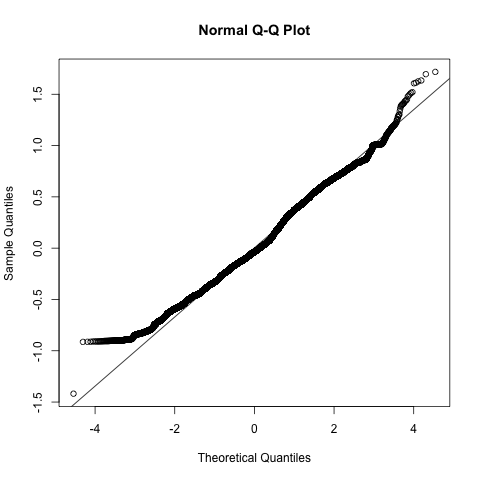

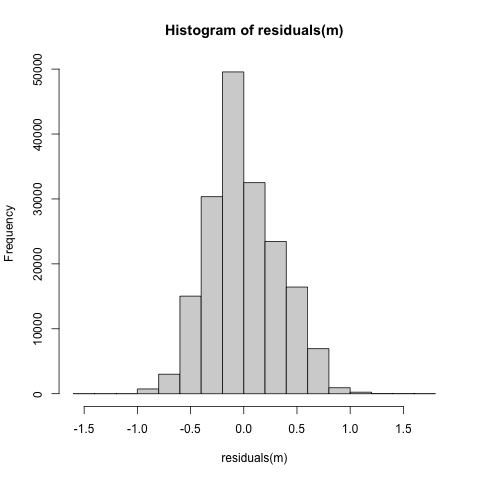

In [29]:
%%R -i all_df

# Sanitize dataframe column names
library(janitor)
all_df <- clean_names(all_df)

all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)

# Use a QQ plot and histogram to check normality
# We use log_time because we already checked that runtime_ms is not normal
m = aov(log_time ~ condition*benchmark, data=all_df)
qqnorm(residuals(m))
qqline(residuals(m))
hist(residuals(m))

# Anovas

In this section, we perform a series of stats in order to determine whether the differences are significant for various comparisons.

We have the following set of questions we want to ask:
1. Two-way ANOVA with three independent variables: Docker vs Native, Benchmark, and OS. This probably won't show anything useful and it will probably hide a lot of valuable information, but it's a start.
2. For each benchmark, do a two-way ANOVA with two variables: Docker vs Native and OS. This shows any interaction effect.
3. For each benchmark and OS (that's `NUM_OSs * NUM_BENCHMARKS`—it's a lot of tests!), do a one-way ANOVA considering just Docker vs Native. This shows if there is a signficant difference for each column of the massive relative performance graph showing all benches/OSs.

In [30]:
%%R -i all_df

library(tidyverse) # Used for filtering out data irrelevant to a given test
library(janitor) # Fix dataframe column names to sanitize
# Libraries for the ezANOVA
library(ez)
library(apa)
library(lsr)
all_df <- clean_names(all_df)

all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$source_video <- factor(all_df$source_video)
all_df$kernel_width_number_pixels <- factor(all_df$kernel_width_number_pixels)

# print(head(all_df))

# type=1 only if we removed stuff
anoResults <- ezANOVA(data=all_df, type=1, dv=log_time, wid=device, within=c(condition, benchmark), between=operating_system)
print(anoResults)

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                                Effect DFn DFd            F            p p<.05
1                     operating_system   2   4 1.549894e+00 3.174163e-01      
2                            condition   1   4 2.239320e-03 9.645255e-01      
4                            benchmark  15  60 1.258966e+03 4.663976e-69     *
3           operating_system:condition   2   4 6.871293e+00 5.082603e-02      
5           operating_system:benchmark  30  60 2.496638e+00 1.290247e-03     *
6                  condition:benchmark  15  60 1.949667e+01 1.205400e-17     *
7 operating_system:condition:benchmark  30  60 7.156230e+00 6.297927e-11     *
           ges
1 3.446060e-01
2 1.196916e-05
4 9.865882e-01
3 6.842857e-02
5 2.258604e-01
6 2.445164e-01
7 1.919810e-01



## Significance of Docker on Each Benchmark

The following does a TON of anovas (one for each comparison we want to make). The reason this is done as a crapload of separate anovas instead of a single beast is because we can only do a Tukey on a single variable, making it kinda useless for our use case. We want to know if, for each benchmark & os, docker changes performance. So, that's a lot of combinations and each one needs a test somehow!

If somebody knows how to do this better, you are welcome to refactor this. Otherwise, this should calculate everything we need. It does not do all the checks it ought to regarding normality, etc, which may be a weakness.

In [46]:
%%R -i all_df -o significance

library(janitor) # Fix dataframe column names to sanitize
all_df <- clean_names(all_df)

library(multcomp)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)

significance <- data.frame(benchmark = character(),
             os = character(),
             p = double()) 

print("**************************** For each benchmark, look for differences ****************************")
for (b in levels(all_df$benchmark)) {
    bench_df <- filter(all_df, benchmark == b)

    print("------------------------------------------------------------")
    print(b)
    print("------------------------------------------------------------")
    print("--------------------------Overall---------------------------")
    
    print(ezANOVA(data=bench_df, type=1, dv=log_time, wid=device, within=condition, between=operating_system))
    
    print("The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey")
    m = aov(log_time ~ condition * operating_system, data=bench_df)
    print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    # For each OS, we do individual t-tests for each benchmark and OS
    print(paste("--------------------------Test condition diffs by OS---------------------------"))
    print("The following compares conditions for a single OS")
    for (os in levels(bench_df$operating_system)) {
        print(paste("--------------------------OS: ", os, "---------------------------"))
        os_bench_df <- filter(bench_df, operating_system == os)
        
        d_os_bench_df <- filter(os_bench_df, condition == "Docker")
        print(paste("Docker: Mean: ", mean(d_os_bench_df$runtime_ms), ", StDev: ", sd(d_os_bench_df$runtime_ms)))
        n_os_bench_df <- filter(os_bench_df, condition == "Native")
        print(paste("Native: Mean: ", mean(n_os_bench_df$runtime_ms), ", StDev: ", sd(n_os_bench_df$runtime_ms)))
        print(paste("Difference: Absolute: ", mean(d_os_bench_df$runtime_ms) - mean(n_os_bench_df$runtime_ms),
                    ", Percent: ", (mean(d_os_bench_df$runtime_ms)/mean(n_os_bench_df$runtime_ms) - 1) * 100, "%"))
        
        t_result <- t.test(log_time ~ condition, var.equal=FALSE, paired=FALSE, data=os_bench_df)
        print(t_result)
#         m = aov(log_time ~ condition, data=os_bench_df)
#         m_summary = summary(m)
#         print(m_summary)
#         print(ezANOVA(data=os_bench_df, type=1, dv=log_time, wid=device, within=condition))
        # generalized eta squared
        
#         print(t_result$statistic)
#         print(t_result$p.value)
        
        significance[nrow(significance) + 1,] = list(b, os, t_result$p.value)
    }
    
    print(paste("--------------------------Test OS diffs by condition---------------------------"))
    print("This shows differences in OS for a specific benchmark and condition")
    for (c in levels(all_df$condition)) {
        cond_df <- filter(bench_df, condition == c)
        print(paste("--------------------------Condition: ", c, "---------------------------"))
        print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system))
        m = aov(log_time ~ operating_system, data=bench_df)
        print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    }
}

print("**************************** For each condition (overall, over all benchmarks), look for differences between OSs ****************************")
print("Note that none of the differences are significant")
for (c in levels(all_df$condition)) {
    cond_df <- filter(all_df, condition == c)
    
    print("------------------------------------------------------------")
    print(c)
    print("------------------------------------------------------------")
    print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system))
#     m <- aov(log_time ~ operating_system, data=cond_df)
#     print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
}

# print(head(significance))


[1] "**************************** For each benchmark, look for differences ****************************"
[1] "------------------------------------------------------------"
[1] "Brightness Randomization"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  2.157424 0.231425576       0.5046530
2                  condition   1   4 51.671654 0.001984234     * 0.4177998
3 operating_system:condition   2   4 25.769581 0.005187061     * 0.4171755

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)  
Ubuntu - macOS == 0   -0.001236   0.009179  -0.135   0.8929  
Windows - macOS == 0   0.024668   0.010055   2.453   0.0283 *
Windows - Ubuntu == 0  0.025904   0.009179   2.822   0.0143 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Tes

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd          F         p p<.05        ges
1 operating_system   2   4 0.09914721 0.9077666       0.04723214


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.031869   0.006762  -4.713 2.47e-06 ***
Windows - macOS == 0   0.133345   0.007407  18.002  < 2e-16 ***
Windows - Ubuntu == 0  0.165213   0.006762  24.434  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F          p p<.05       ges
1 operating_system   2   4 4.752828 0.08771797       0.7038278


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.031869   0.006762  -4.713 2.47e-06 ***
Windows - macOS == 0   0.133345   0.007407  18.002  < 2e-16 ***
Windows - Ubuntu == 0  0.165213   0.006762  24.434  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Compute Canny"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F          p p<.05         ges
1           operating_system   2   4 1.441950 0.33763758       0.413895733
2                  condition   1   4 1.272652 0.32235228       0.006486232
3 operating_system:condition   2   4 5.077609 0.07985219       0.049515724

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.04274    0.01247   3.429 0.000609 ***
Windows - macOS == 0   0.16166    0.01366  11.837  < 2e-16 ***
Windows - Ubuntu == 0  0.11892    0.01247   9.538  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "-------------------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05      ges
1 operating_system   2   4 1.086634 0.4198457       0.352045


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.084709   0.008832   9.591   <2e-16 ***
Windows - macOS == 0  0.219442   0.009675  22.682   <2e-16 ***
Windows - Ubuntu == 0 0.134733   0.008832  15.256   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 1.777656 0.2802949       0.4705712


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.084709   0.008832   9.591   <2e-16 ***
Windows - macOS == 0  0.219442   0.009675  22.682   <2e-16 ***
Windows - Ubuntu == 0 0.134733   0.008832  15.256   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Compute Histogram"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F          p p<.05         ges
1           operating_system   2   4 1.9750480 0.25314843       0.483265331
2                  condition   1   4 0.3379794 0.59218355       0.004454537
3 operating_system:condition   2   4 6.7273200 0.05251679       0.151193156

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.213477   0.008489   25.15   <2e-16 ***
Windows - macOS == 0  0.466034   0.009298   50.12   <2e-16 ***
Windows - Ubuntu == 0 0.252557   0.008485   29.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "---------------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 4.268353 0.1018013       0.6809369


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.267518   0.006176   43.32   <2e-16 ***
Windows - macOS == 0  0.367499   0.006765   54.32   <2e-16 ***
Windows - Ubuntu == 0 0.099981   0.006175   16.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 1.246026 0.3796259       0.3838621


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.267518   0.006176   43.32   <2e-16 ***
Windows - macOS == 0  0.367499   0.006765   54.32   <2e-16 ***
Windows - Ubuntu == 0 0.099981   0.006175   16.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Contour"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F         p p<.05        ges
1           operating_system   2   4  1.543265 0.3186051       0.41893502
2                  condition   1   4  1.327779 0.3133808       0.02132615
3 operating_system:condition   2   4 12.002697 0.0204003     * 0.28262175

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.008071   0.008377   0.964 0.335313    
Windows - macOS == 0  0.041233   0.009178   4.493 2.13e-05 ***
Windows - Ubuntu == 0 0.033162   0.008378   3.958 0.000152 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Tes

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05        ges
1 operating_system   2   4 0.1980343 0.8279251       0.09009609


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.054601   0.006023   9.066   <2e-16 ***
Windows - macOS == 0  0.163363   0.006598  24.759   <2e-16 ***
Windows - Ubuntu == 0 0.108763   0.006023  18.057   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       F         p p<.05       ges
1 operating_system   2   4 2.93291 0.1643818       0.5945598


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.054601   0.006023   9.066   <2e-16 ***
Windows - macOS == 0  0.163363   0.006598  24.759   <2e-16 ***
Windows - Ubuntu == 0 0.108763   0.006023  18.057   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Contrast Randomization"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F            p p<.05       ges
1           operating_system   2   4   1.780732 0.2798389426       0.4676049
2                  condition   1   4 127.900350 0.0003484200     * 0.3022479
3 operating_system:condition   2   4 178.099420 0.0001233205     * 0.5467682

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.026996   0.008788  -3.072  0.00427 ** 
Windows - macOS == 0  -0.052423   0.009627  -5.445 1.58e-07 ***
Windows - Ubuntu == 0 -0.025427   0.008788  -2.893  0.00427 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "-------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd          F         p p<.05        ges
1 operating_system   2   4 0.08695584 0.9184034       0.04166635


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                        Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -5.809e-06  6.929e-03  -0.001    0.999    
Windows - macOS == 0   2.176e-01  7.590e-03  28.673   <2e-16 ***
Windows - Ubuntu == 0  2.176e-01  6.929e-03  31.411   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F          p p<.05       ges
1 operating_system   2   4 7.010965 0.04926261     * 0.7780482


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                        Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -5.809e-06  6.929e-03  -0.001    0.999    
Windows - macOS == 0   2.176e-01  7.590e-03  28.673   <2e-16 ***
Windows - Ubuntu == 0  2.176e-01  6.929e-03  31.411   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Gaussian Blur"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F         p p<.05          ges
1           operating_system   2   4 1.5254802 0.3218277       0.4323319093
2                  condition   1   4 3.6125321 0.1301388       0.0013566848
3 operating_system:condition   2   4 0.2464896 0.7925947       0.0001853553

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.22836    0.01299  17.580  < 2e-16 ***
Windows - macOS == 0   0.28920    0.01423  20.325  < 2e-16 ***
Windows - Ubuntu == 0  0.06084    0.01299   4.685 2.84e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "---------------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 1.613211 0.3063891       0.4464757


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.224330   0.009184  24.427  < 2e-16 ***
Windows - macOS == 0  0.288225   0.010060  28.650  < 2e-16 ***
Windows - Ubuntu == 0 0.063895   0.009183   6.958 3.64e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F        p p<.05       ges
1 operating_system   2   4 1.440761 0.337871       0.4187333


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.224330   0.009184  24.427  < 2e-16 ***
Windows - macOS == 0  0.288225   0.010060  28.650  < 2e-16 ***
Windows - Ubuntu == 0 0.063895   0.009183   6.958 3.64e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Good Features"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  1.294703 0.368491439       0.3828265
2                  condition   1   4 17.252175 0.014219019     * 0.1527588
3 operating_system:condition   2   4 35.865329 0.002789822     * 0.4284580

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)
Ubuntu - macOS == 0    0.004264   0.009476   0.450    0.653
Windows - macOS == 0  -0.011642   0.010380  -1.121    0.524
Windows - Ubuntu == 0 -0.015906   0.009476  -1.679    0.280
(Adjusted p values reported -- holm method)

[1] "--------------------------Test condition diffs by OS---------------------------"
[1] "The following comp

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd          F         p p<.05       ges
1 operating_system   2   4 0.02857945 0.9720217       0.0140884


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.047034   0.006877    6.84 8.36e-12 ***
Windows - macOS == 0  0.143237   0.007533   19.01  < 2e-16 ***
Windows - Ubuntu == 0 0.096204   0.006877   13.99  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 3.969708 0.1122416       0.6649752


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.047034   0.006877    6.84 8.36e-12 ***
Windows - macOS == 0  0.143237   0.007533   19.01  < 2e-16 ***
Windows - Ubuntu == 0 0.096204   0.006877   13.99  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Gradient Sobel"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05       ges
1           operating_system   2   4  3.312319 0.141739783       0.5910662
2                  condition   1   4  5.380928 0.081164939       0.1461783
3 operating_system:condition   2   4 27.190241 0.004694449     * 0.6337293

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.136335   0.008978 -15.186  < 2e-16 ***
Windows - macOS == 0  -0.070456   0.009834  -7.164 8.32e-13 ***
Windows - Ubuntu == 0  0.065879   0.008978   7.338 4.63e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "---------------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F        p p<.05       ges
1 operating_system   2   4 3.804838 0.118708       0.6554598


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.024362   0.006684  -3.645 0.000269 ***
Windows - macOS == 0   0.161014   0.007322  21.992  < 2e-16 ***
Windows - Ubuntu == 0  0.185376   0.006684  27.735  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F          p p<.05       ges
1 operating_system   2   4 6.951554 0.04991868     * 0.7765751


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.024362   0.006684  -3.645 0.000269 ***
Windows - macOS == 0   0.161014   0.007322  21.992  < 2e-16 ***
Windows - Ubuntu == 0  0.185376   0.006684  27.735  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Hough Lines"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F            p p<.05       ges
1           operating_system   2   4   2.556505 0.1926621256       0.5414717
2                  condition   1   4 151.275788 0.0002510219     * 0.7423071
3 operating_system:condition   2   4   6.705402 0.0527815717       0.2034208

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.34736    0.01038  33.449  < 2e-16 ***
Windows - macOS == 0   0.41439    0.01138  36.427  < 2e-16 ***
Windows - Ubuntu == 0  0.06703    0.01038   6.455 1.13e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "-----------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 3.886358 0.1154427       0.6602313


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.235055   0.008534  27.544  < 2e-16 ***
Windows - macOS == 0  0.284578   0.009348  30.441  < 2e-16 ***
Windows - Ubuntu == 0 0.049523   0.008534   5.803 6.69e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F        p p<.05       ges
1 operating_system   2   4 0.9737714 0.452319       0.3274534


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.235055   0.008534  27.544  < 2e-16 ***
Windows - macOS == 0  0.284578   0.009348  30.441  < 2e-16 ***
Windows - Ubuntu == 0 0.049523   0.008534   5.803 6.69e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Mean Thresholding"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F          p p<.05       ges
1           operating_system   2   4 1.602477 0.30821768       0.4182708
2                  condition   1   4 8.664195 0.04224164     * 0.1818613
3 operating_system:condition   2   4 3.819070 0.11812800       0.1638533

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.005472   0.009398  -0.582     0.56    
Windows - macOS == 0   0.048211   0.010295   4.683 5.72e-06 ***
Windows - Ubuntu == 0  0.053684   0.009398   5.712 3.43e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Tes

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F        p p<.05       ges
1 operating_system   2   4 0.6037826 0.589998       0.2318867


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.026251   0.006686   3.926 8.68e-05 ***
Windows - macOS == 0  0.107043   0.007324  14.615  < 2e-16 ***
Windows - Ubuntu == 0 0.080792   0.006686  12.084  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 2.512641 0.1964258       0.5568005


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.026251   0.006686   3.926 8.68e-05 ***
Windows - macOS == 0  0.107043   0.007324  14.615  < 2e-16 ***
Windows - Ubuntu == 0 0.080792   0.006686  12.084  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Measure Memory Usage"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          F           p p<.05       ges
1           operating_system   2   4  0.7860299 0.515333597       0.2786406
2                  condition   1   4 63.4659440 0.001345159     * 0.2139844
3 operating_system:condition   2   4 53.1191970 0.001316601     * 0.3130515

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.129727   0.008158 -15.902   <2e-16 ***
Windows - macOS == 0   0.075533   0.008937   8.452   <2e-16 ***
Windows - Ubuntu == 0  0.205261   0.008158  25.160   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "-----------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 3.380288 0.1381812       0.6282727


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.015653   0.005960  -2.626  0.00864 ** 
Windows - macOS == 0   0.095668   0.006529  14.653  < 2e-16 ***
Windows - Ubuntu == 0  0.111321   0.005960  18.678  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05       ges
1 operating_system   2   4 0.6321347 0.5773561       0.2401605


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.015653   0.005960  -2.626  0.00864 ** 
Windows - macOS == 0   0.095668   0.006529  14.653  < 2e-16 ***
Windows - Ubuntu == 0  0.111321   0.005960  18.678  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Mirror"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        F          p p<.05       ges
1           operating_system   2   4 1.368341 0.35255572       0.3137723
2                  condition   1   4 4.773772 0.09422757       0.2835886
3 operating_system:condition   2   4 2.028282 0.24650184       0.2517068

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.04219    0.01175   3.591 0.000662 ***
Windows - macOS == 0   0.05587    0.01287   4.340 4.31e-05 ***
Windows - Ubuntu == 0  0.01367    0.01175   1.163 0.244681    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Test co

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05        ges
1 operating_system   2   4 0.1815508 0.8404838       0.08322099


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.289480   0.009001   32.16   <2e-16 ***
Windows - macOS == 0   0.182458   0.009860   18.50   <2e-16 ***
Windows - Ubuntu == 0 -0.107022   0.009001  -11.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       F         p p<.05       ges
1 operating_system   2   4 1.72085 0.2889188       0.4624884


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.289480   0.009001   32.16   <2e-16 ***
Windows - macOS == 0   0.182458   0.009860   18.50   <2e-16 ***
Windows - Ubuntu == 0 -0.107022   0.009001  -11.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Resize"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05        ges
1           operating_system   2   4  1.459423 0.334235523       0.41678932
2                  condition   1   4 18.907269 0.012173803     * 0.08891147
3 operating_system:condition   2   4 26.256375 0.005009877     * 0.21324260

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.065407   0.007323   8.931  < 2e-16 ***
Windows - macOS == 0  0.089154   0.008022  11.113  < 2e-16 ***
Windows - Ubuntu == 0 0.023747   0.007323   3.243  0.00119 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "---------------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 0.274122 0.7734504       0.1205397


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.184445   0.005386  34.245  < 2e-16 ***
Windows - macOS == 0  0.218212   0.005900  36.984  < 2e-16 ***
Windows - Ubuntu == 0 0.033767   0.005386   6.269 3.76e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 3.080221 0.1549868       0.6063164


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.184445   0.005386  34.245  < 2e-16 ***
Windows - macOS == 0  0.218212   0.005900  36.984  < 2e-16 ***
Windows - Ubuntu == 0 0.033767   0.005386   6.269 3.76e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "Rotate"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F          p p<.05        ges
1           operating_system   2   4 0.5814632 0.60024438       0.20121730
2                  condition   1   4 0.8809003 0.40109390       0.02857039
3 operating_system:condition   2   4 5.5575450 0.07003232       0.27065865

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)   
Ubuntu - macOS == 0   -0.028627   0.009830  -2.912  0.00719 **
Windows - macOS == 0   0.002239   0.010768   0.208  0.83527   
Windows - Ubuntu == 0  0.030866   0.009828   3.141  0.00507 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "-------------------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd          F         p p<.05        ges
1 operating_system   2   4 0.09623532 0.9102903       0.04590865


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.114371   0.007090  16.131  < 2e-16 ***
Windows - macOS == 0   0.095466   0.007767  12.292  < 2e-16 ***
Windows - Ubuntu == 0 -0.018905   0.007089  -2.667  0.00767 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 1.606669 0.3075016       0.4454718


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.114371   0.007090  16.131  < 2e-16 ***
Windows - macOS == 0   0.095466   0.007767  12.292  < 2e-16 ***
Windows - Ubuntu == 0 -0.018905   0.007089  -2.667  0.00767 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "SIFT"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F         p p<.05        ges
1           operating_system   2   4 0.8213187 0.5025227       0.28271124
2                  condition   1   4 4.3864220 0.1043133       0.04225209
3 operating_system:condition   2   4 1.1682641 0.3984898       0.02295990

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.03135    0.01056   2.969  0.00299 ** 
Windows - macOS == 0   0.12749    0.01157  11.023  < 2e-16 ***
Windows - Ubuntu == 0  0.09614    0.01056   9.106  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Tes

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F        p p<.05       ges
1 operating_system   2   4 1.086559 0.419866       0.3520293


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.060876   0.007481   8.138 4.44e-16 ***
Windows - macOS == 0  0.137439   0.008195  16.771  < 2e-16 ***
Windows - Ubuntu == 0 0.076564   0.007481  10.235  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05       ges
1 operating_system   2   4 0.7030684 0.5474518       0.2601001


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.060876   0.007481   8.138 4.44e-16 ***
Windows - macOS == 0  0.137439   0.008195  16.771  < 2e-16 ***
Windows - Ubuntu == 0 0.076564   0.007481  10.235  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "------------------------------------------------------------"
[1] "SURF"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         F           p p<.05         ges
1           operating_system   2   4  2.775395 0.175404741       0.580228166
2                  condition   1   4 39.311782 0.003302362     * 0.037170964
3 operating_system:condition   2   4  4.683434 0.089548993       0.009114852

[1] "The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey"

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ condition * operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.31753    0.01165   27.25   <2e-16 ***
Windows - macOS == 0   0.48241    0.01277   37.78   <2e-16 ***
Windows - Ubuntu == 0  0.16488    0.01165   14.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "-----------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 2.389958 0.2075579       0.5444148


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.356429   0.008283   43.03   <2e-16 ***
Windows - macOS == 0  0.504525   0.009073   55.61   <2e-16 ***
Windows - Ubuntu == 0 0.148096   0.008283   17.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native ---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        F         p p<.05       ges
1 operating_system   2   4 3.198303 0.1480256       0.6152591


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = bench_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.356429   0.008283   43.03   <2e-16 ***
Windows - macOS == 0  0.504525   0.009073   55.61   <2e-16 ***
Windows - Ubuntu == 0 0.148096   0.008283   17.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "**************************** For each condition (overall, over all benchmarks), look for differences between OSs ****************************"
[1] "Note that none of the differences are significant"
[1] "------------------------------------------------------------"
[1] "Docker"
[1] "----------------------------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05       ges
1 operating_system   2   4 0.9182072 0.4697078       0.3146477

[1] "------------------------------------------------------------"
[1] "Native"
[1] "------------------------------------------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd      F         p p<.05       ges
1 operating_system   2   4 2.1187 0.2357978       0.5144099



                  benchmark       os              p
1  Brightness Randomization    macOS   3.973662e-12
2  Brightness Randomization   Ubuntu   6.485701e-03
3  Brightness Randomization  Windows  3.589310e-196
4             Compute Canny    macOS   3.085284e-09
5             Compute Canny   Ubuntu   9.139468e-01


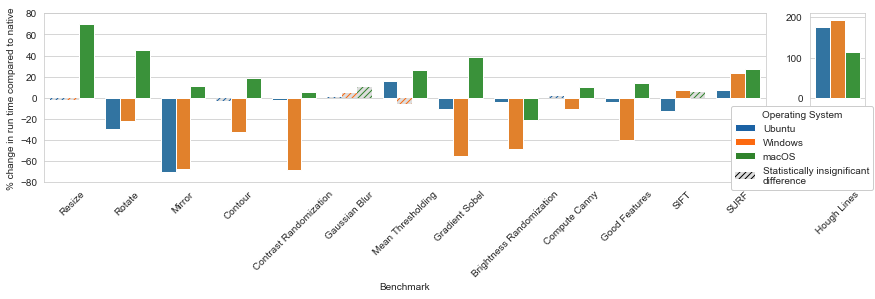

In [33]:
print(significance.head())

sns.set_style("whitegrid")

all_means = all_df.groupby(['Benchmark', 'Operating System', 'Condition']).mean()

# Gets % diff compared to native
perf_ratios = all_means.groupby(['Benchmark', 'Operating System']).apply(
    lambda d : (d.loc[ : , : , 'Docker'] / d.loc[ : , : , 'Native'] - 1) * 100
)
# Fix the naming of the performance ratio for runtime
perf_ratios.rename(inplace=True, columns={
    'Runtime (ms)': '% change in run time compared to native'
})
# Fix a random problem with the index
perf_ratios = perf_ratios.reset_index(level=[1,2], drop=True).reset_index()

# Turn the benchmark into a category so we can sort it
perf_ratios['Benchmark'] = perf_ratios['Benchmark'].astype('category')

# Ready for plotting
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(12)
fig.set_figheight(4)
widths=[13, 1]
yMax = [80, 210]
yMin = [-80, -210]
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
benchSets = [
  ['Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast Randomization',
   'Gaussian Blur', 'Mean Thresholding', 'Gradient Sobel',
   'Brightness Randomization', 'Compute Canny', 'Good Features',
   'SIFT', 'SURF'],
  ['Hough Lines']
]
oss = ['Ubuntu', 'Windows', 'macOS']
colors = ['#1b62a4', '#fc6910', '#30832c']

# Make the axes
axes = []
for col in range(2):
  axes += [fig.add_subplot(gs[0, col])]

# For each subset of benchmarks, draw it and have fun!
for col, benches in enumerate(benchSets):
  ratios_subset = perf_ratios[perf_ratios['Benchmark'].isin(benches)]
  
  # Sort the benchmarks because they're probably out of order now
  ratios_subset['Benchmark'].cat.set_categories(benches, inplace=True)
  ratios_subset.sort_values(['Benchmark'])

  b = sns.barplot(
      x='Benchmark', y='% change in run time compared to native',
      hue='Operating System', hue_order=oss,
      data=ratios_subset, ax=axes[col],
  )
    
  for i, bar in enumerate(b.patches):
    # Get the benchmark and os for this bar using math
    curr_bench = benchSets[col][i % len(benches)]
    os = oss[i // len(benches)]
    
    # If the difference is insignificant, make the bar gray
    if significance[(significance['benchmark'] == curr_bench) & (significance['os'] == os)].iloc[0]['p'] > 0.05:
      bar.set(color='#DDD', linewidth=0, edgecolor=colors[i // len(benches)], hatch='////')
#       bar.set_hatch('xxxx')

  axes[col].set_xticklabels(axes[col].get_xticklabels(), rotation=45)

  # Set the y limit
  axes[col].set_ylim(ymax=yMax[col], ymin=yMin[col])

  # Only first subfig has axes
  if col != 0:
    axes[col].set_ylabel(None)
    axes[col].set_xlabel(None)
    
  # Only second subfig has legend
#   if col != 1:
  axes[col].get_legend().set_visible(False)

legend_elements = []
legend_labels = oss + ['Statistically insignificant\ndifference']
for i, os in enumerate(oss):
  legend_elements += [patches.Patch(facecolor=colors[i])]
legend_elements += [patches.Patch(facecolor='#DDD', hatch='////', edgecolor='#000', linewidth=0)]

# fig.legend(legend_elements, legend_labels, framealpha=1, loc=(0.84, 0.36), title='Operating System')
fig.legend(legend_elements, legend_labels, framealpha=1, loc=(0.835, 0.365), title='Operating System')

plt.savefig('relative.pdf')